In [1]:
!pip install autogluon.multimodal



  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.


In [2]:
!pip install torchaudio

  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.0.0 requires torch<2.1,>=2.0, but you have torch 2.1.0 which is incompatible.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.


In [3]:
!pip install opencv-python

<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:22:50. Analyzing...


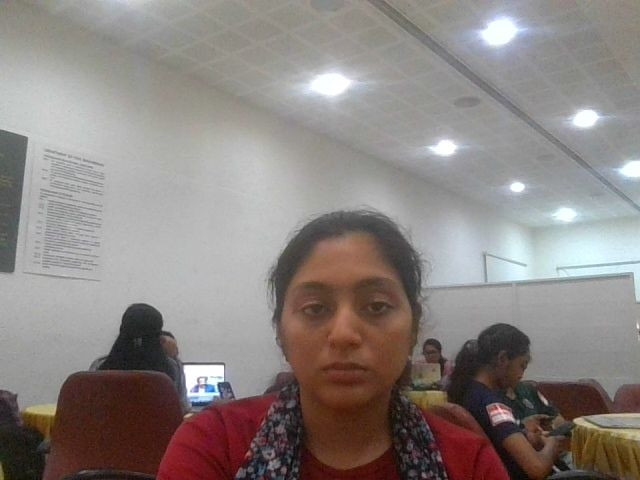

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:22:50.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:23:29. Analyzing...


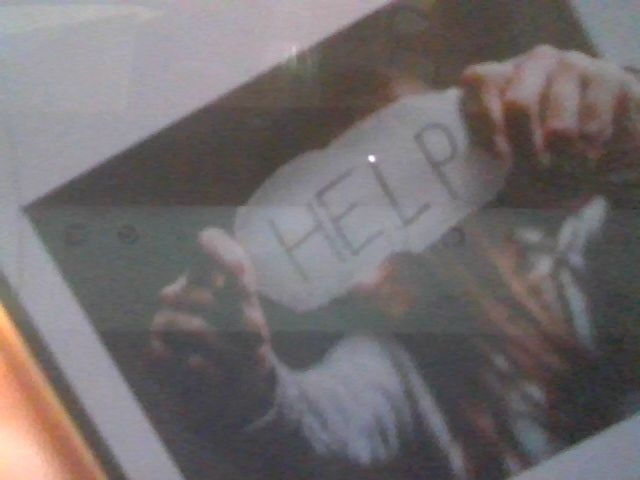

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:23:29.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:25:19. Analyzing...


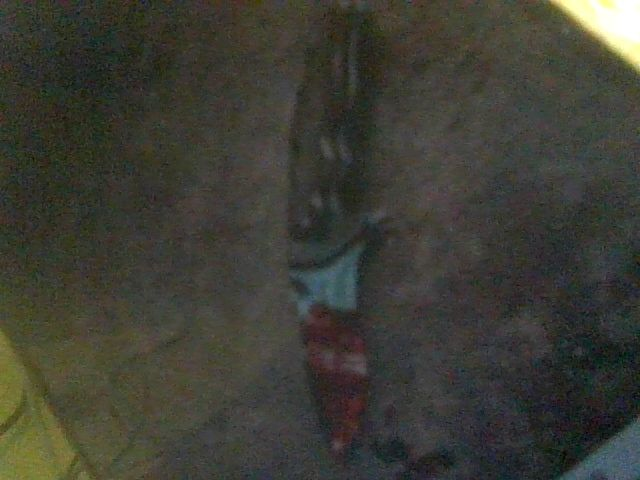

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Violence detected at 2024-03-10 04:25:19!


<IPython.core.display.Javascript object>

Violence detected at the following timestamps:
2024-03-10 04:25:19


In [5]:
# -*- coding: utf-8 -*-
import cv2
import os
import time
from IPython.display import Image, display
from autogluon.multimodal import MultiModalPredictor
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def capture_frames(video_path, output_folder='frames'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    vidObj = cv2.VideoCapture(video_path)
    count = 0
    frame_interval = 1
    fps = int(vidObj.get(cv2.CAP_PROP_FPS))
    frame_time = 1 / fps

    frame_urls = []

    while True:
        success, image = vidObj.read()

        if not success:
            break

        current_time = vidObj.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

        if current_time >= count * frame_interval:
            frame_name = os.path.join(output_folder, "frame%d.jpg" % count)
            cv2.imwrite(frame_name, image)
            frame_urls.append(frame_name)
            count += 1

    vidObj.release()

    return frame_urls

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

if __name__ == '__main__':
    video_path = "t_w023_converted.avi"
    output_folder = "frames"
    class_labels = ['Violence', 'Normal']
    predictor = MultiModalPredictor(problem_type="zero_shot_image_classification")

    violence_timestamps = []

    try:
        while True:
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
            filename = take_photo()
            print(f'Image captured at {current_time}. Analyzing...')
            pil_img = Image(filename=filename)
            display(pil_img)

            prob = predictor.predict_proba({"image": [filename]}, {"text": class_labels})
            violence_prob = prob[0][0]

            if violence_prob > 0.5:
                print(f"Violence detected at {current_time}!")
                violence_timestamps.append(current_time)
            else:
                print(f"No violence detected at {current_time}.")

            time.sleep(1)

    except KeyboardInterrupt:
        if len(violence_timestamps) > 0:
            print("Violence detected at the following timestamps:")
            for timestamp in violence_timestamps:
                print(timestamp)
        else:
            print("No violence detected.")

In [7]:
import cv2
import os
import time
from autogluon.multimodal import MultiModalPredictor
from IPython.display import Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='temp_photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();

          await new Promise((resolve) => setTimeout(resolve, 1000));

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          document.body.removeChild(video);
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

if __name__ == '__main__':
    video_path = "t_w023_converted.avi"
    class_labels = ['Violence', 'Normal']
    predictor = MultiModalPredictor(problem_type="zero_shot_image_classification")

    violence_timestamps = []

    try:
        while True:
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
            filename = "temp_photo.jpg"
            take_photo(filename)
            print(f'Image captured at {current_time}. Analyzing...')

            try:
                prob = predictor.predict_proba({"image": [filename]}, {"text": class_labels})
                violence_prob = prob[0][0]
            except Exception as e:
                print(f"Error during prediction: {e}")
                continue

            if violence_prob > 0.5:
                print(f"Violence detected at {current_time}!")
                violence_timestamps.append(current_time)
            else:
                print(f"No violence detected at {current_time}.")

            time.sleep(1)

    except KeyboardInterrupt:
        if len(violence_timestamps) > 0:
            print("Violence detected at the following timestamps:")
            for timestamp in violence_timestamps:
                print(timestamp)
        else:
            print("No violence detected.")

<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:40:56. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:40:56.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:41:24. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Violence detected at 2024-03-10 04:41:24!


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:41:41. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Violence detected at 2024-03-10 04:41:41!


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:41:59. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:41:59.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:42:17. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:42:17.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:42:33. Analyzing...


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

No violence detected at 2024-03-10 04:42:33.


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:42:50. Analyzing...


Predicting: 0it [00:00, ?it/s]

Error during prediction: 'NoneType' object is not iterable


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<IPython.core.display.Javascript object>

Image captured at 2024-03-10 04:43:00. Analyzing...


Predicting: 0it [00:00, ?it/s]

Error during prediction: 'NoneType' object is not iterable


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<IPython.core.display.Javascript object>

Violence detected at the following timestamps:
2024-03-10 04:41:24
2024-03-10 04:41:41
